In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
sns.set(style= 'darkgrid')
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection  import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from pyod.models.ecod import ECOD
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Import the algorithms to be used 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, RANSACRegressor, HuberRegressor
from sklearn.linear_model import LinearRegression

import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('train (1).csv')
data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

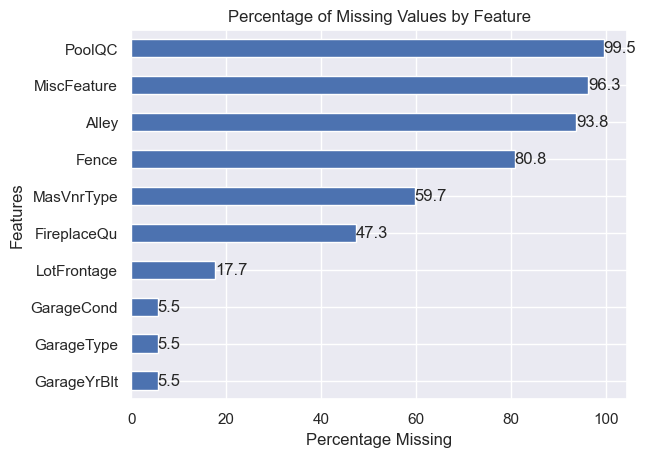

In [4]:
# Create a function that displays a bar chart of top or all missing information
def missingInfo(dataframe, show_all = False, percentage_missing = True):
    missing_rows = []
    perc_missing = []

    for i in dataframe.columns:
        missing_rows.append(dataframe[i].isnull().sum())
        perc_missing.append(dataframe[i].isnull().sum()/len(dataframe) * 100)  

    if show_all == False:
        if percentage_missing == True:
            fig = pd.Series(perc_missing, index = dataframe.columns).sort_values(ascending = True).tail(10).plot(kind = 'barh')
        else:
            fig = pd.Series(missing_rows, index = dataframe.columns).sort_values(ascending = True).tail(10).plot(kind = 'barh')
    else:
        plt.figure(figsize = (9, 15))
        if percentage_missing == True:
            fig = pd.Series(perc_missing, index = dataframe.columns).sort_values(ascending = True).plot(kind = 'barh')
        else:
            fig = pd.Series(missing_rows, index = dataframe.columns).sort_values(ascending = True).plot(kind = 'barh')
        
    fig.bar_label(fig.containers[0], fmt = '%.1f')
    plt.xlabel('Percentage Missing')
    plt.ylabel('Features')
    plt.title('Percentage of Missing Values by Feature')
    plt.show()


missingInfo(data, show_all = False, percentage_missing= True)

In [3]:
df = data.copy()

# Check that individual features are representated in their right data type before filling the missing values
cat = df.select_dtypes(include = 'object')
num = df.select_dtypes(include = 'number')
display(num.head())
display(cat.head())


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


All columns are represented in their expected data types.

In [4]:
# Create a cleaning function that checks if the missing values of a column is above 30% then drops the column
                                # fills the numerical columns with mean, and categorical columns with mode 
def cleaner(dataframe):
    for i in dataframe.columns:
        if (dataframe[i].isnull().sum()/len(dataframe) * 100) > 30:
            dataframe.drop(i, inplace = True, axis = 1)

        elif dataframe[i].dtypes != 'O':
            dataframe[i].fillna(dataframe[i].median(), inplace = True)

        else:
            dataframe[i].fillna(dataframe[i].mode()[0], inplace = True)

    print(dataframe.isnull().sum().sort_values(ascending = False).head())
    print(f'\n\t\t\tDATAFRAME IS CLEANED')
    return dataframe

cleaner(df)

Id              0
GarageYrBlt     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
dtype: int64

			DATAFRAME IS CLEANED


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,112,0,0,0,0,4,2010,WD,Normal,142125


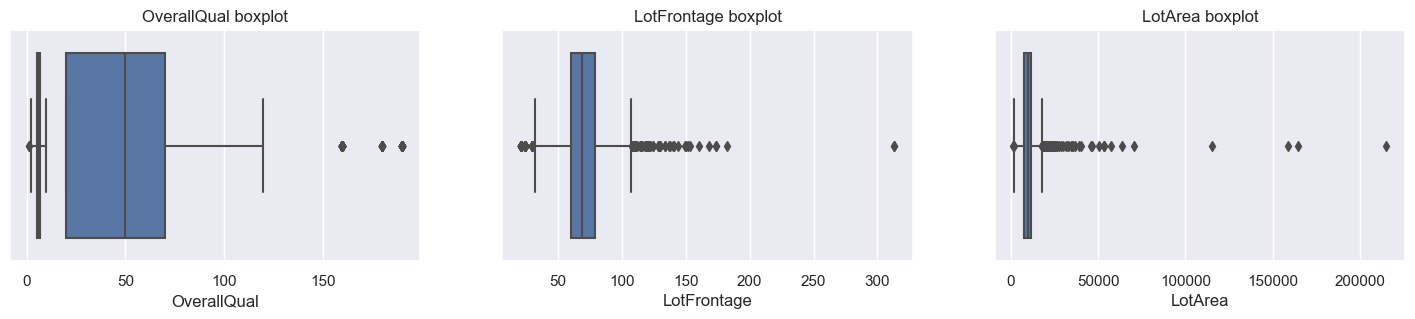

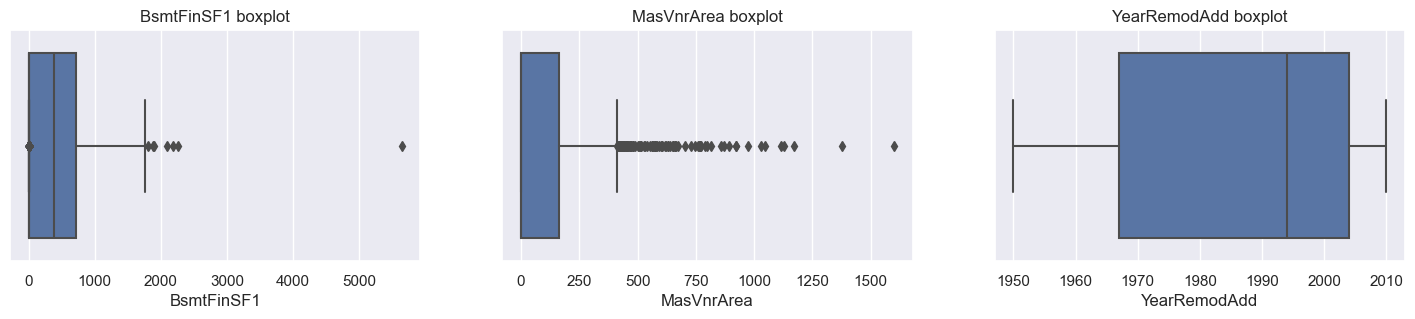

In [7]:
# Checking for outlier

# ------------ CHECKING FOR OUTLIERS -------------------
def outlierChecker(dataframe, a,b,c,d):
    plt.figure(figsize = (18, 3))
    sns.set(style = 'darkgrid')

    plt.subplot(1, 3, 1)
    sns.boxplot(x = dataframe[a])
    plt.title(f"{a} boxplot")

    plt.subplot(1, 3, 2)
    sns.boxplot(x = dataframe[b])
    plt.title(f"{b} boxplot")

    plt.subplot(1, 3, 3)
    sns.boxplot(x = dataframe[c])
    plt.title(f"{c} boxplot")

    plt.subplot(1, 3, 1)
    sns.boxplot(x = dataframe[d])
    plt.title(f"{d} boxplot")

outlierChecker(df, 'MSSubClass', 'LotFrontage',	'LotArea', 'OverallQual')
outlierChecker(df, 'OverallCond', 'MasVnrArea',	'YearRemodAdd', 'BsmtFinSF1')

Presence of outlier is visible from the subsets of columns plotted above. <br>
Linear Regression is responsive to outliers. So we drop outlier rows using the ECOD library

In [5]:
# Remove the outliers
def outlierRemover(column, threshold=3):
    z_scores = stats.zscore(column)
    return column[(abs(z_scores) < threshold)]

# Call the function to remove outliers
for i in df.columns:
    if df[i].dtype != 'O':  # Check for numeric columns
        df[i] = outlierRemover(df[i])

df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60.0,RL,65.0,8450.0,Pave,Reg,Lvl,AllPub,Inside,...,0.0,0.0,0.0,0.0,0.0,2,2008,WD,Normal,208500.0
1,2,20.0,RL,80.0,9600.0,Pave,Reg,Lvl,AllPub,FR2,...,0.0,0.0,0.0,0.0,0.0,5,2007,WD,Normal,181500.0
2,3,60.0,RL,68.0,11250.0,Pave,IR1,Lvl,AllPub,Inside,...,0.0,0.0,0.0,0.0,0.0,9,2008,WD,Normal,223500.0
3,4,70.0,RL,60.0,9550.0,Pave,IR1,Lvl,AllPub,Corner,...,NaN,0.0,0.0,0.0,0.0,2,2006,WD,Abnorml,140000.0
4,5,60.0,RL,84.0,14260.0,Pave,IR1,Lvl,AllPub,FR2,...,0.0,0.0,0.0,0.0,0.0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60.0,RL,62.0,7917.0,Pave,Reg,Lvl,AllPub,Inside,...,0.0,0.0,0.0,0.0,0.0,8,2007,WD,Normal,175000.0
1456,1457,20.0,RL,85.0,13175.0,Pave,Reg,Lvl,AllPub,Inside,...,0.0,0.0,0.0,0.0,0.0,2,2010,WD,Normal,210000.0
1457,1458,70.0,RL,66.0,9042.0,Pave,Reg,Lvl,AllPub,Inside,...,0.0,0.0,0.0,0.0,NaN,5,2010,WD,Normal,266500.0
1458,1459,20.0,RL,68.0,9717.0,Pave,Reg,Lvl,AllPub,Inside,...,112.0,0.0,0.0,0.0,0.0,4,2010,WD,Normal,142125.0


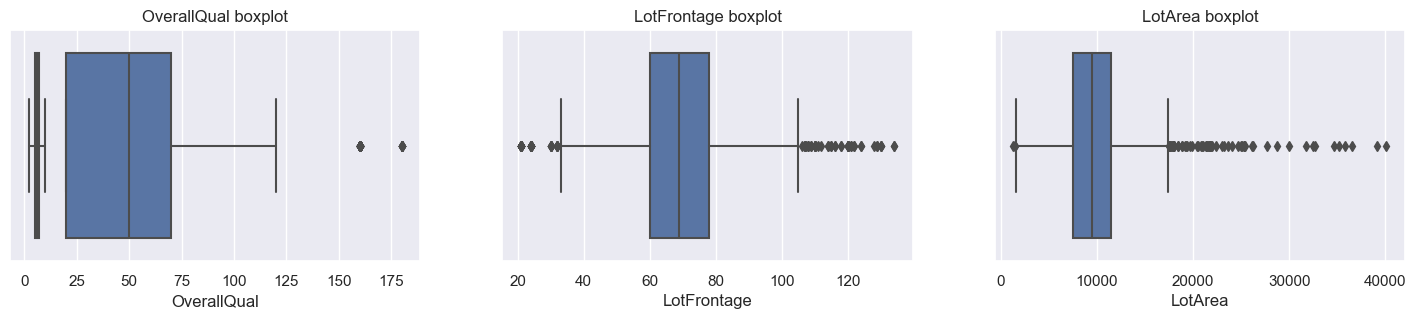

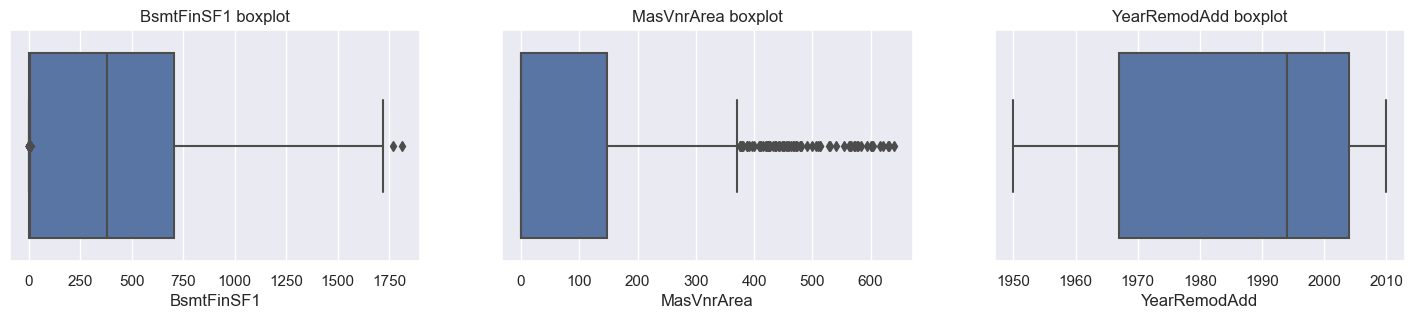

In [9]:
# Call the outlier checker function to check if outliers has been removed
outlierChecker(df, 'MSSubClass', 'LotFrontage',	'LotArea', 'OverallQual')
outlierChecker(df, 'OverallCond', 'MasVnrArea',	'YearRemodAdd', 'BsmtFinSF1')

<h3 style = "color:#FF2171"><b><center>Feature Selection</b></h3></center><hr style = "width:400px;text-align:center;color:#EDB7ED">

In [6]:
# Ascertain MulitColinearity
# The dataset is large, we cannot plot all features at once. We therefore plot in batches of 15 

def corrMatrix(dataframe, start, stop):
    plt.figure(figsize = (18, 6))

    subset_df = dataframe.select_dtypes(include='number').iloc[:, start:stop]
    subset_df['SalePrice'] = dataframe.SalePrice

    correlation_matrix = subset_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='GnBu')
    plt.show()

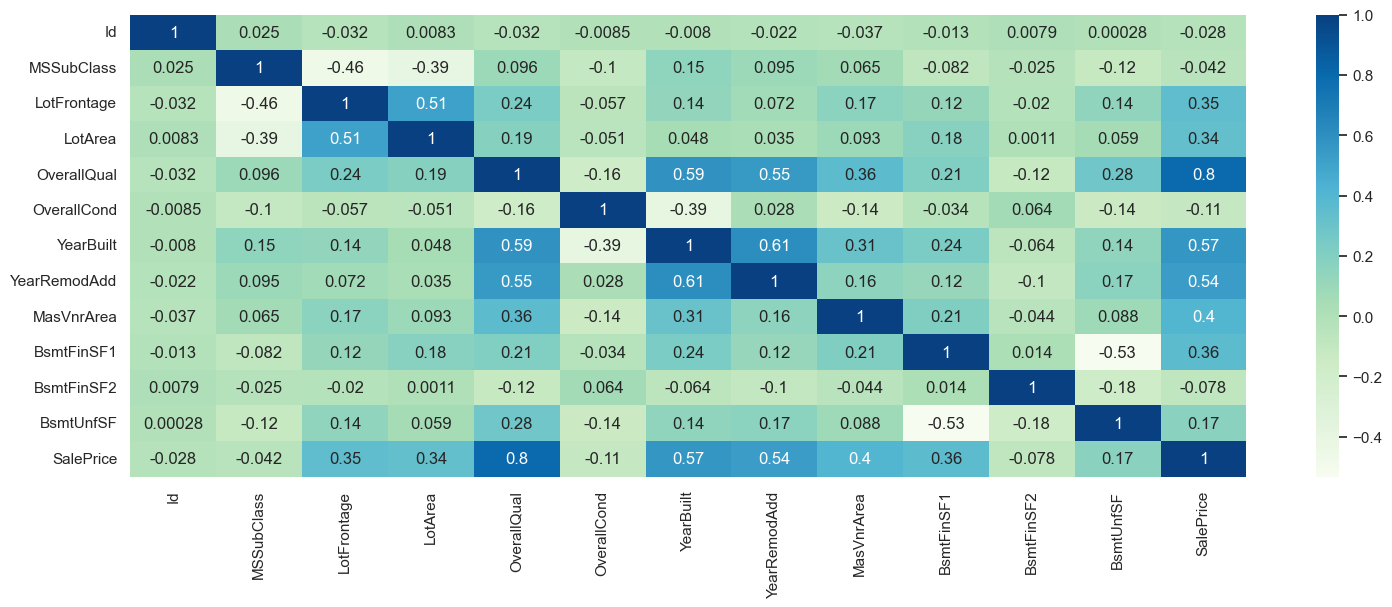

In [20]:
corrMatrix(df, 0, 12)

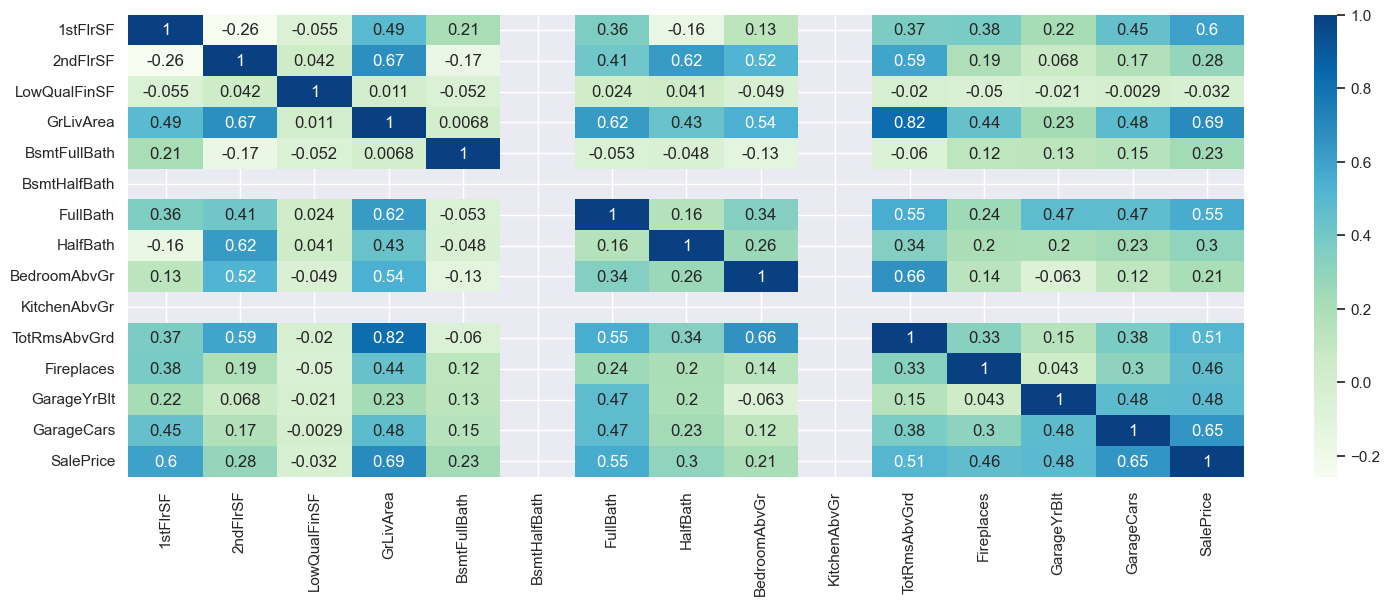

In [21]:
corrMatrix(df, 13, 27)

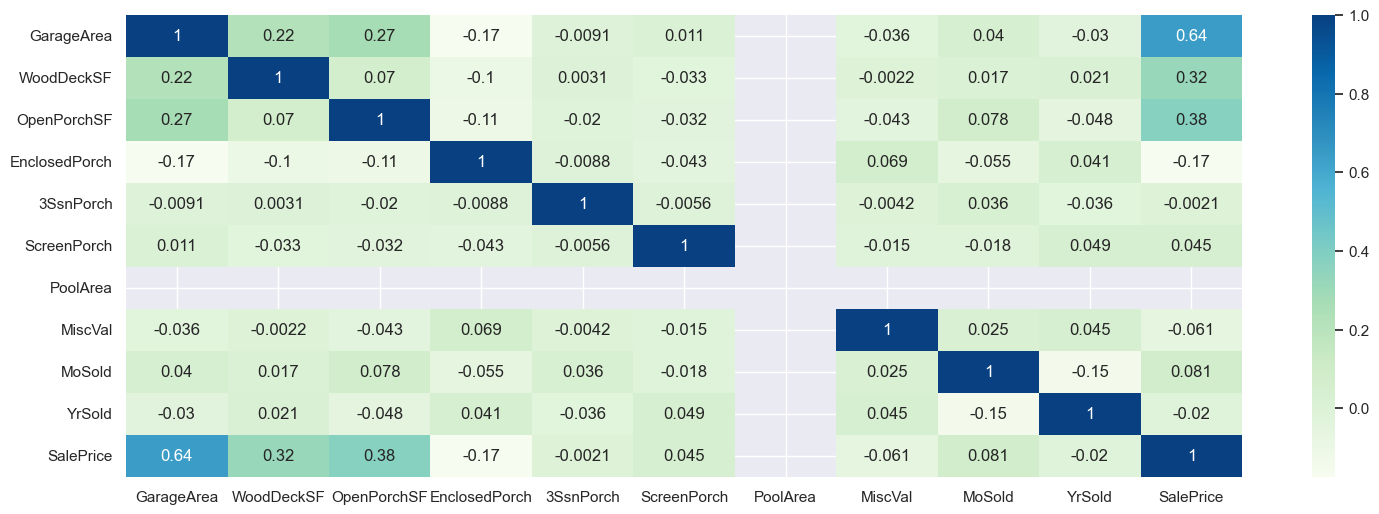

In [22]:
corrMatrix(df, 27, 38)

In [7]:
# Create a function that calculates correlation coefficient for all variables. Using a threshold of 50%

def correlated_columns(dataframe, target_column, threshold):
    corr_matrix = dataframe.corr()

    # Extract columns with correlation above the threshold
    correlated_cols = corr_matrix[[target_column]].loc[(corr_matrix[target_column] > threshold) | (corr_matrix[target_column] < -threshold)]
    return correlated_cols.sort_values(by = 'SalePrice', ascending = False)
 

correlated = correlated_columns(df.select_dtypes(include='number'), 'SalePrice', 0.40)
correlated

,SalePrice
SalePrice,1.000000
OverallQual,0.796433
GrLivArea,0.694729
GarageCars,0.651158
GarageArea,0.641598
TotalBsmtSF,0.619648
1stFlrSF,0.597583
YearBuilt,0.569055
FullBath,0.553524
YearRemodAdd,0.536864


Listed above are the columns that have atleast 30% correlation with the target variable.<br>
They are the features that are considered good fit to capture the dependency of individual houses' price
We will check for multicolinearity among these chosen features<br>
<ul>
<li>OverallQual: Overall material and finish quality</li>
<li>GrLivArea: Above grade (ground) living area square feet</li>
<li>GarageCars: Size of garage in car capacity</li>
<li>GarageArea: Size of garage in square feet</li>
<li>TotalBsmtSF: Total square feet of basement area</li>
<li>1stFlrSF: First Floor square feet</li>
<li>Original construction date</li>
<li>FullBath: Full bathrooms above grade</li>
<li>TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)</li>
<li>YearRemodAdd: Remodel date</li>
<li>Fireplaces: Number of fireplaces</li>
<li>MasVnrArea: Masonry veneer area in square feet</li>
<li>OpenPorchSF: Open porch area in square feet</li>
<li>BsmtFinSF1: Type 1 finished square feet</li>
<li>LotFrontage: Linear feet of street connected to property</li>
<li>LotArea: Lot size in square feet</li>
<li>WoodDeckSF: Wood deck area in square feet</li>
</ul>

In [8]:
# Extract the selected columns with good correlation from the main dataframe
selected_features = df[correlated.index.to_list()]
selected_features.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,Fireplaces,MasVnrArea
0,208500.0,7.0,1710.0,2,548.0,856.0,856.0,2003.0,2,2003,8.0,2003.0,0.0,196.0
1,181500.0,6.0,1262.0,2,460.0,1262.0,1262.0,1976.0,2,1976,6.0,1976.0,1.0,0.0
2,223500.0,7.0,1786.0,2,608.0,920.0,920.0,2001.0,2,2002,6.0,2001.0,1.0,162.0
3,140000.0,7.0,1717.0,3,642.0,756.0,961.0,1915.0,1,1970,7.0,1998.0,1.0,0.0
4,250000.0,8.0,2198.0,3,836.0,1145.0,1145.0,2000.0,2,2000,9.0,2000.0,1.0,350.0


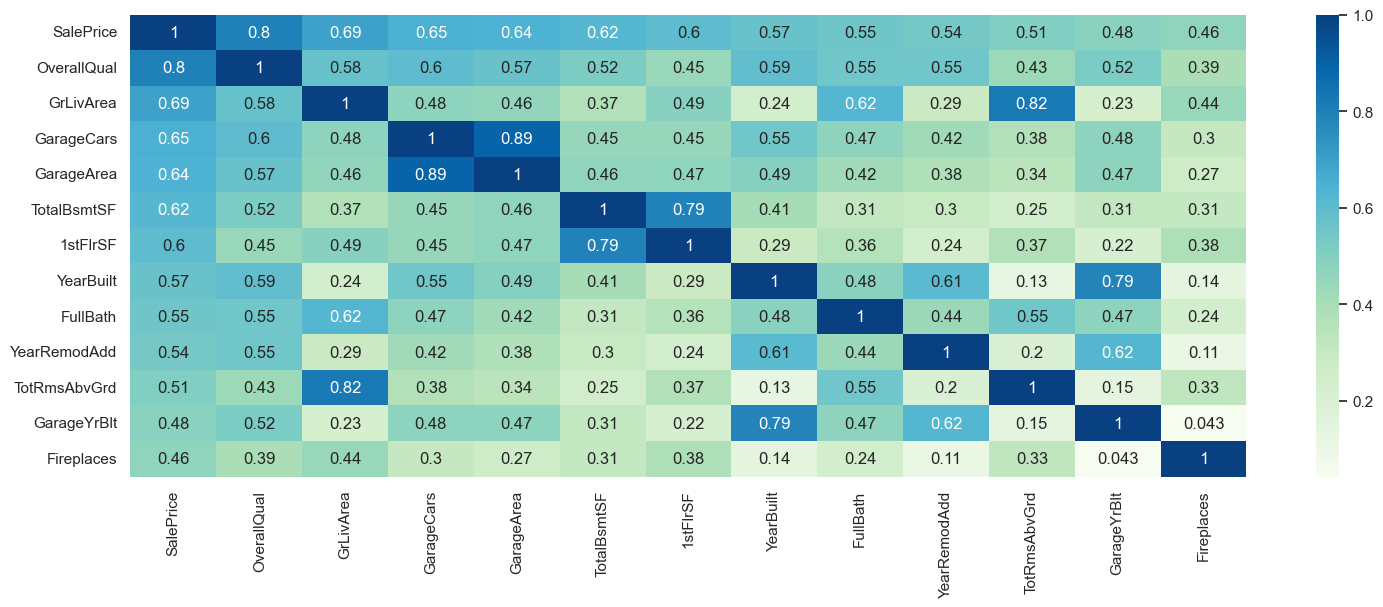

In [42]:
# check for multicolinearity between these selected features 
corrMatrix(selected_features, 0, 20)

The highest Mulitcolinearity Visible in this matrix is 82% correlation btw two Independent Variables.<br>
By practice, the multicolinearity is not to a worrisome degree.

Check if the distribution has a high standard deviation. <br>
If it does, then we scale the distribution to have a mean of 0, and a variance of 1

In [38]:
selected_features.describe()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,Fireplaces,MasVnrArea
count,1438.000000,1458.000000,1444.000000,1460.000000,1453.000000,1450.000000,1448.000000,1454.000000,1460.000000,1460.000000,1448.000000,1458.000000,1455.000000,1428.000000
mean,175844.522253,6.106310,1491.332410,1.767123,469.111493,1043.248276,1149.029006,1971.653370,1.565068,1984.865753,6.470994,1978.692730,0.604811,86.110644
std,67475.861228,1.370971,469.785633,0.747315,206.777678,395.951281,353.293094,29.660447,0.550916,20.645407,1.547404,23.849136,0.630368,138.163895
min,34900.000000,2.000000,334.000000,0.000000,0.000000,0.000000,334.000000,1882.000000,0.000000,1950.000000,2.000000,1908.000000,0.000000,0.000000
25%,129500.000000,5.000000,1126.000000,1.000000,328.000000,794.250000,881.500000,1954.000000,1.000000,1967.000000,5.000000,1962.000000,0.000000,0.000000
50%,161500.000000,6.000000,1456.000000,2.000000,478.000000,990.000000,1082.000000,1973.000000,2.000000,1994.000000,6.000000,1980.000000,1.000000,0.000000
75%,210000.000000,7.000000,1768.000000,2.000000,576.000000,1284.000000,1381.250000,2000.750000,2.000000,2004.000000,7.000000,2001.000000,1.000000,148.000000
max,415298.000000,10.000000,3086.000000,4.000000,1069.000000,2330.000000,2259.000000,2010.000000,3.000000,2010.000000,11.000000,2010.000000,2.000000,640.000000


<Axes: xlabel='SalePrice', ylabel='Count'>

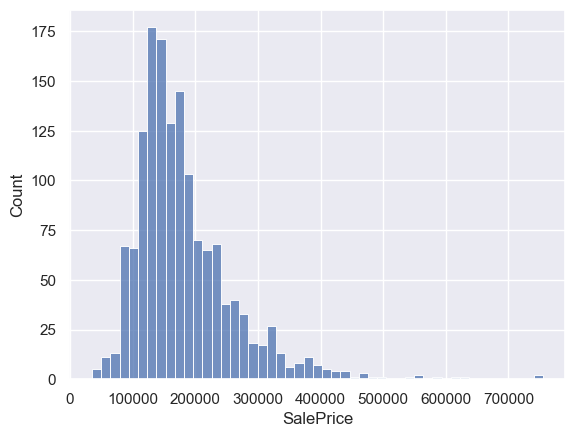

In [26]:
sns.histplot(x = data['SalePrice'])


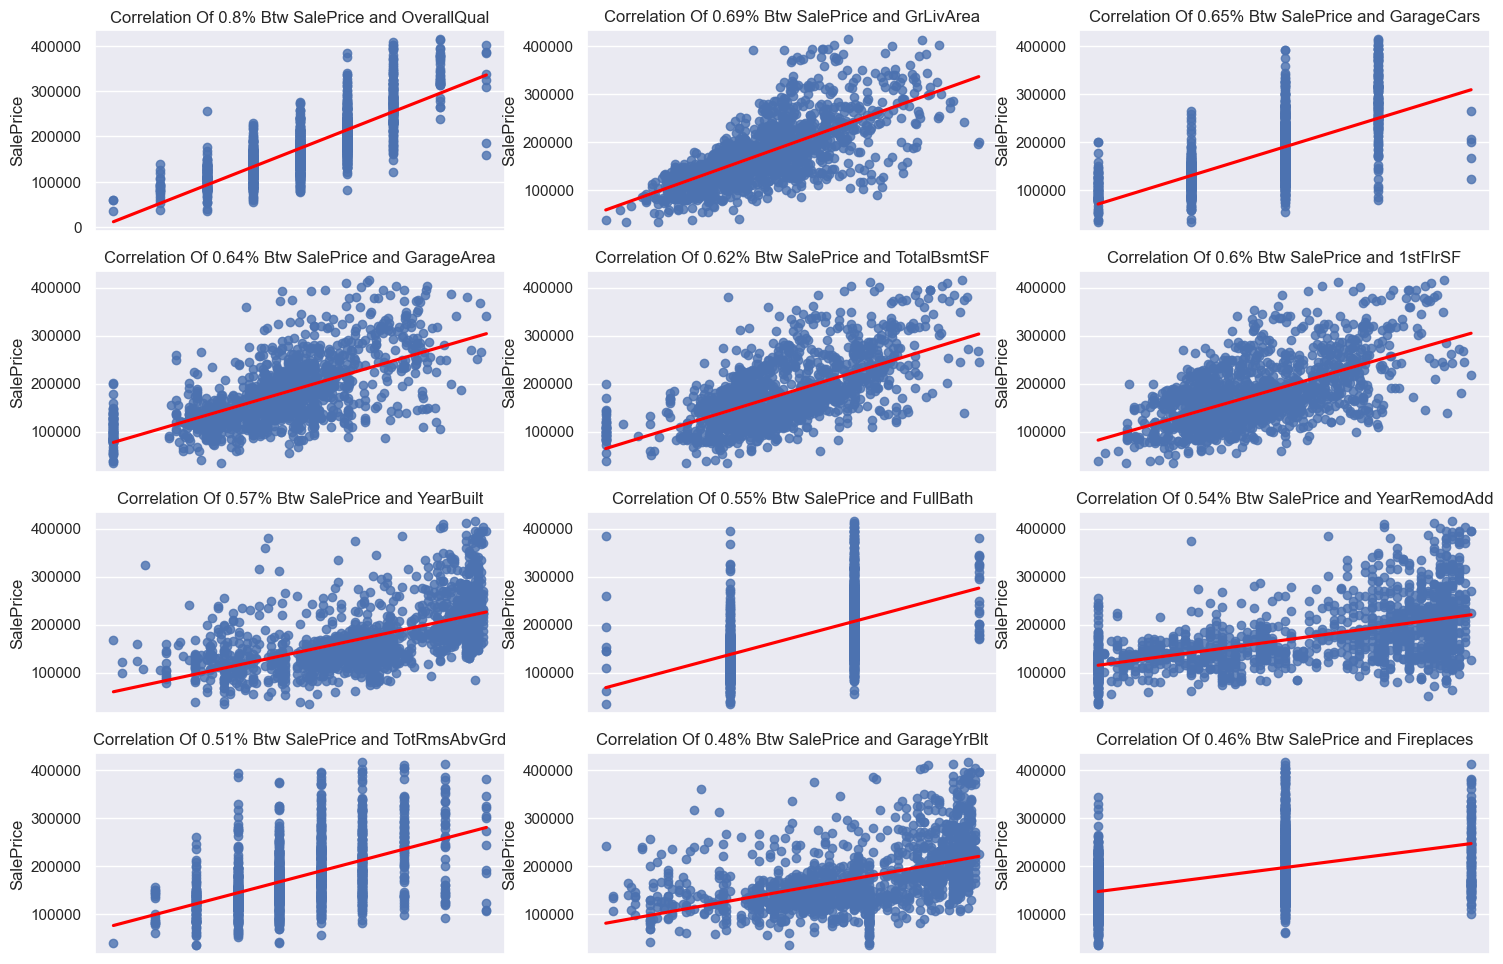

In [43]:
plt.figure(figsize=(18,12))
sns.set(style = 'darkgrid')
for i, col in enumerate(selected_features.drop('SalePrice', axis = 1)):
    ax = plt.subplot(4, 3, i+1)
    sns.regplot(x = selected_features[col], y = selected_features['SalePrice'], ax=ax, ci = 0, line_kws={'color': 'red'})
    plt.xlabel(i)
    plt.title(f'Correlation Of {selected_features.SalePrice.corr(selected_features[col]).round(2)}% Btw SalePrice and {col}')
    ax = plt.gca()
# Hide the x-axis
    ax.xaxis.set_visible(False)

In [9]:
# The distribution has a high standard deviation, therefore we scale 
def scaler(dataframe, target = None):
    if target != None:
        scaler = StandardScaler()
        for i in dataframe.drop(target, axis = 1):
            dataframe[i] = scaler.fit_transform(dataframe[[i]])
        return dataframe
    else:
        scaler = StandardScaler()
        for i in dataframe:
            dataframe[i] = scaler.fit_transform(dataframe[[i]])
        return dataframe


new_data = selected_features.copy()

new_data = scaler(new_data, target = 'SalePrice')
new_data.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,TotRmsAbvGrd,GarageYrBlt,Fireplaces,MasVnrArea
0,208500.0,0.65209,0.465624,0.311725,0.381645,-0.473071,-0.829708,1.057213,0.789741,0.878668,0.988452,1.019559,-0.959787,0.795634
1,181500.0,-0.07757,-0.488333,0.311725,-0.044079,0.552662,0.319876,0.146597,0.789741,-0.429577,-0.304482,-0.112946,0.627134,-0.623468
2,223500.0,0.65209,0.627456,0.311725,0.671912,-0.311379,-0.648493,0.989760,0.789741,0.830215,-0.304482,0.935670,0.627134,0.549463
3,140000.0,0.65209,0.480529,1.650307,0.836396,-0.725714,-0.532402,-1.910722,-1.026041,-0.720298,0.341985,0.809836,0.627134,-0.623468
4,250000.0,1.38175,1.504755,1.650307,1.774925,0.257069,-0.011408,0.956034,0.789741,0.733308,1.634919,0.893725,0.627134,1.910642


In [10]:
# Clean the data 
for i in new_data:
    new_data[i].fillna(new_data[i].median(), inplace = True)

new_data.isnull().sum().sort_values(ascending= False).head(3)

SalePrice      0
OverallQual    0
GrLivArea      0
dtype: int64

<h3 style = "color:#FF2171"><b><center>Linear Regression Modelling</b></h3></center><hr style = "width:400px;text-align:center;color:#EDB7ED">

In [11]:
# split into train and test
x = new_data.drop('SalePrice', axis = 1)
y = new_data.SalePrice

score = []


# Use loop to identify the random-state that yields the best score  
for i in range(100):
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.1, random_state = i)
    lin_reg = LinearRegression()
    lin_reg.fit(xtrain, ytrain)
    score.append(r2_score(lin_reg.predict(xtrain), ytrain))
    
np.array(score).argmax()


34

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.1, random_state = 34)
print(f'Xtrain: {xtrain.shape}')
print(f'Ytrain: {ytest.shape}')
print(f'Xtest: {xtest.shape}')
print(f'Ytest: {ytest.shape}')

Xtrain: (1314, 13)
Ytrain: (146,)
Xtest: (146, 13)
Ytest: (146,)


In [13]:
# Creating BaseLine Model to check the goodness of the LinearRegression Algorithm
ymean = ytrain.mean()
baseline_model = [ymean] * len(ytrain)
baseline_mean_absolute_error = mean_absolute_error(baseline_model, ytrain)

baseline_mean_absolute_error

51629.310406140175

In [14]:
lin_reg = LinearRegression()
lin_reg.fit(xtrain, ytrain)

LinearRegression()

In [17]:
cross_val = lin_reg.predict(xtrain)

cross_val_error = mean_absolute_error(cross_val, ytrain)
print(f'R2 Score of the model is: {r2_score(cross_val, ytrain).round(2)}')
print(f'Mean Absolute Error on Cross Validation is : {cross_val_error.round(2)}')

R2 Score of the model is: 0.7
Mean Absolute Error on Cross Validation is : 21527.11


The mean absolute error for the cross validation is lower than the baseline model error.<br>
This is an indication that the model performs better than using average price of houses to predict the price of new houses 

In [18]:
# testing the model on the test data set aside 
test_predicted = lin_reg.predict(xtest)

print(f'R2 Score of the model is: {r2_score(test_predicted, ytest).round(2)}')
print(f'Mean Absolute Error on Cross Validation is : {mean_absolute_error(test_predicted, ytest).round(2)}')

R2 Score of the model is: 0.53
Mean Absolute Error on Cross Validation is : 27162.01


<h3 style = "color:#FF2171"><b><center>Randomized Search CV</b></h3></center><hr style = "width:400px;text-align:center;color:#EDB7ED">

In [21]:
# Conducting RandomSearch CV to ascertain best paramenters for modelling

randomSearchModel = LinearRegression()
param_grid = {
    'fit_intercept': [True, False],  # Whether to calculate the intercept
    'copy_X': [True, False],  # Whether to copy the data
    'n_jobs': [None, 1, 2, 4, 6, 8, 10],  # Number of jobs to use for computation
    'positive': [False, True]  # Whether to constrain coefficients to be positive
   
}

# Perform Randomized Search CV
random_search = RandomizedSearchCV(estimator = randomSearchModel, param_distributions = param_grid, n_iter = 10, cv = 7, scoring = 'r2')
random_search.fit(xtrain, ytrain)


# Print the best parameters and best score on the test set
print("Best Parameters:", random_search.best_params_)
print("Best Score on Train Set (R^2):", random_search.best_estimator_.score(xtrain, ytrain))

Best Parameters: {'positive': True, 'n_jobs': 10, 'fit_intercept': True, 'copy_X': False}
Best Score on Train Set (R^2): 0.7700300630708443


In [22]:
# creating a randomly searched model 
new_lin_reg = LinearRegression(positive = False, n_jobs = 8, fit_intercept = True, copy_X = False )
new_lin_reg.fit(xtrain, ytrain)

cross_val = new_lin_reg.predict(xtrain)
cross_val_error = mean_absolute_error(cross_val, ytrain)
print(f'R2 Score of the model is: {r2_score(cross_val, ytrain).round(3)}')
print(f'Mean Absolute Error on Cross Validation is : {cross_val_error.round(3)}')

R2 Score of the model is: 0.704
Mean Absolute Error on Cross Validation is : 21527.114


<h3 style = "color:#FF2171"><b><center>Decision</b></h3></center><hr style = "width:400px;text-align:center;color:#EDB7ED">

In a context of predictive sensitive information, a model with an accuracy of 63% might seem unacceptable as it falls short of the desired reliability for deployment due to several reasons:
<ol>
<li>Prediction Reliability: A 63% accuracy suggests that nearly 40% of predictions could be incorrect. In a high-stakes scenario like house price prediction, this margin of error could lead to significant financial implications for buyers, sellers, and stakeholders.</li>
<li>Complexity of Decision Making: Housing markets often involve multifaceted factors influencing prices (location, market trends, property conditions, etc.). A model with only 63% accuracy may not effectively capture these complexities, potentially leading to misleading or unreliable predictions.</li>
<li>Customer Trust and Confidence: Deploying a model with moderate accuracy might erode customer trust. Inaccurate predictions could harm the reputation and credibility of the deployed system, impacting user satisfaction and adoption.</li>
<li>Risk Mitigation and Regulatory Compliance: In industries like real estate, where substantial investments are at stake, regulatory and compliance standards demand higher accuracy and reliability in predictive models to ensure fair and transparent transactions</li>
<li>Business Impact: Inaccurate predictions could lead to financial losses or missed opportunities for the business. Deploying a model with limited accuracy might hinder the company's ability to optimize decision-making and gain a competitive edge in the market.</li>
</ol>
While the current model does not demonstrates a potential necessary for deployment, it requires further refinement and improvement to meet the stringent criteria necessary for deployment in a production environment. Additional feature engineering, model tuning, and possibly exploring more advanced algorithms or ensemble techniques could enhance its performance and reliability for deployment.

<h3 style = "color:#FF2171"><b><center>Using Other Advanced Algorithm</b></h3></center><hr style = "width:400px;text-align:center;color:#EDB7ED">

In [23]:
# Prepare the Data 
dfs = df.copy()
from sklearn.preprocessing import LabelEncoder
for i in dfs.columns:
    if dfs[i].dtypes == 'O':
        dfs[i] = LabelEncoder().fit_transform(dfs[i])

dfs.dropna(inplace = True)
dfs

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60.0,3,65.0,8450.0,1,3,3,0,4,...,0.0,0.0,0.0,0.0,0.0,2,2008,8,4,208500.0
2,3,60.0,3,68.0,11250.0,1,0,3,0,4,...,0.0,0.0,0.0,0.0,0.0,9,2008,8,4,223500.0
4,5,60.0,3,84.0,14260.0,1,0,3,0,2,...,0.0,0.0,0.0,0.0,0.0,12,2008,8,4,250000.0
6,7,20.0,3,75.0,10084.0,1,3,3,0,4,...,0.0,0.0,0.0,0.0,0.0,8,2007,8,4,307000.0
10,11,20.0,3,70.0,11200.0,1,3,3,0,4,...,0.0,0.0,0.0,0.0,0.0,2,2008,8,4,129500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,1453,180.0,4,35.0,3675.0,1,3,3,0,4,...,0.0,0.0,0.0,0.0,0.0,5,2006,8,4,145000.0
1453,1454,20.0,3,90.0,17217.0,1,3,3,0,4,...,0.0,0.0,0.0,0.0,0.0,7,2006,8,0,84500.0
1454,1455,20.0,1,62.0,7500.0,1,3,3,0,4,...,0.0,0.0,0.0,0.0,0.0,10,2009,8,4,185000.0
1455,1456,60.0,3,62.0,7917.0,1,3,3,0,4,...,0.0,0.0,0.0,0.0,0.0,8,2007,8,4,175000.0


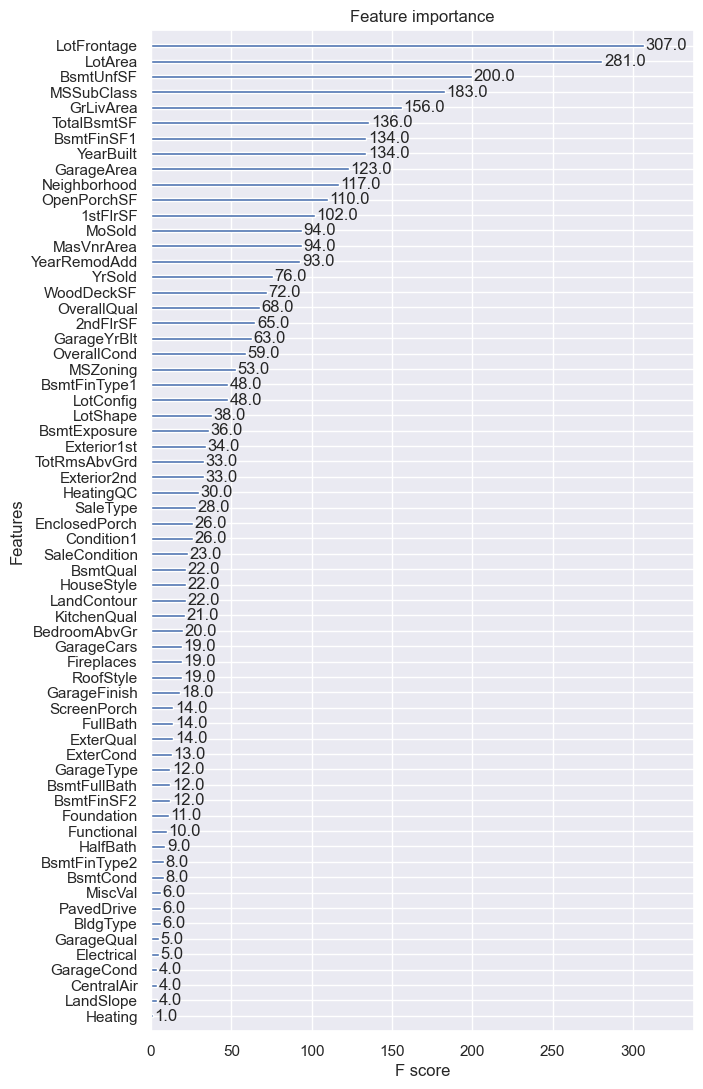

In [24]:
# FEATURE SELECTION

x = dfs.drop(['SalePrice', 'Id'], axis = 1)
y = dfs.SalePrice

# - Using XGBOOST to find feature importance
import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(x, y)


plt.rcParams['figure.figsize'] = (7, 13)
# Print feature importance scores
xgb.plot_importance(model, importance_type= 'weight')
plt.show()

In [116]:
# Select out the best columns as adviced by the XGBoost Best Feature Method 
sel_columns = ['LotFrontage', 'LotArea', 'BsmtUnfSF', 'GrLivArea', 'MSSubClass', 'TotalBsmtSF', 'BsmtFinSF1', 'SalePrice']
new_df = dfs[sel_columns].reset_index(drop = True)
new_df

,LotFrontage,LotArea,BsmtUnfSF,GrLivArea,MSSubClass,TotalBsmtSF,BsmtFinSF1,SalePrice
0,65.0,8450.0,150.0,1710.0,60.0,856.0,706.0,208500.0
1,68.0,11250.0,434.0,1786.0,60.0,920.0,486.0,223500.0
2,84.0,14260.0,490.0,2198.0,60.0,1145.0,655.0,250000.0
3,75.0,10084.0,317.0,1694.0,20.0,1686.0,1369.0,307000.0
4,70.0,11200.0,134.0,1040.0,20.0,1040.0,906.0,129500.0
...,...,...,...,...,...,...,...,...
1010,35.0,3675.0,0.0,1072.0,180.0,547.0,547.0,145000.0
1011,90.0,17217.0,1140.0,1140.0,20.0,1140.0,0.0,84500.0
1012,62.0,7500.0,811.0,1221.0,20.0,1221.0,410.0,185000.0
1013,62.0,7917.0,953.0,1647.0,60.0,953.0,0.0,175000.0


List of features selected as parameters for training<br>
<ol>
<li>LotFrontage: Linear feet of street connected to property</li>
<li>LotArea: Lot size in square feet</li>
<li>BsmtUnfSF: Unfinished square feet of basement area</li>
<li>GrLivArea: Above grade (ground) living area square feet</li>
<li>MSSubClass: The building class</li>
<li>TotalBsmtSF: Total square feet of basement area</li>
<li>BsmtFinSF1: Type 1 finished square feet</li>
</ol>

In [117]:
# Split Into Train and Test
x = new_df.drop(['SalePrice'], axis = 1)
y = new_df['SalePrice']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size = 0.90, random_state = 43)
print(f'xtrain: {xtrain.shape}')
print(f'xtest: {xtest.shape}')
print('ytrain: {}'.format(ytrain.shape))
print('ytest: {}'.format(ytest.shape))

xtrain: (913, 7)
xtest: (102, 7)
ytrain: (913,)
ytest: (102,)


In [124]:
# Import the algorithms to be used 

def modeller(x_train, y_train, x_test, y_test, show_train_score = False):

    # list of algorithms to be used
    modelling_algorithms = [XGBRegressor(), ElasticNet(), HuberRegressor(), GradientBoostingRegressor(), RandomForestRegressor(), 
                          DecisionTreeRegressor(), LinearRegression(), RANSACRegressor()]
    
    algo_names = ['XGBoost Regressor', 'ElasticNet Regressor', 'Huber Regressor', 'Gradient Booster', 'RandomForest Regressor', 
                  'Decision Regressor', 'Linear Regression', 'Ransac Regressor']
    # keep the training and test score
    test_score = []
    train_score = []

    for algorithm in modelling_algorithms:
        algorithm.fit(x_train, y_train)
        model_validate = algorithm.predict(x_train)
        train_score.append(r2_score(model_validate, y_train))

        test_perf = algorithm.predict(x_test)
        test_score.append(r2_score(test_perf, y_test))

    # create a table for each algorithms and test_score
    compare_table = pd.DataFrame()
    compare_table['Algorithm'] = pd.Series(algo_names)
    compare_table['Test Accuracy'] = pd.Series(test_score) * 100

    if show_train_score == True:
        compare_table['Training Accuracy'] = pd.Series(train_score) * 100
        compare_table['Overfitting Gap '] = (compare_table['Training Accuracy'] - compare_table['Test Accuracy']) 
        return compare_table.sort_values(by = 'Test Accuracy', ascending = False).reset_index(drop = True)
    else:
        return compare_table.sort_values(by = 'Test Accuracy', ascending = False).reset_index(drop = True)

In [125]:
model_table = modeller(xtrain, ytrain, xtest, ytest, show_train_score = True)
model_table

,Algorithm,Test Accuracy,Training Accuracy,Overfitting Gap
0,Gradient Booster,84.766335,88.317226,3.550891
1,XGBoost Regressor,83.198347,99.818044,16.619697
2,RandomForest Regressor,81.922217,96.816396,14.894180
3,Linear Regression,75.149152,63.684848,-11.464304
4,ElasticNet Regressor,75.148088,63.682507,-11.465581
5,Huber Regressor,59.452078,45.298046,-14.154033
6,Ransac Regressor,59.439309,48.621264,-10.818046
7,Decision Regressor,44.044543,99.995606,55.951063


The Gradient Boost Algorithm performs the best amongst all other algorithms in terms of test accuarcy and over-fitting gap

In [149]:
gradient_model = GradientBoostingRegressor()
gradient_model.fit(xtrain, ytrain)
print(f'R2_score of the Model: {r2_score(gradient_model.predict(xtest), ytest).round(2)}')
print(f'Mean Absolute Error of Model: {mean_absolute_error(gradient_model.predict(xtest), ytest).round(2)}')

R2_score of the Model: 0.75
Mean Absolute Error of Model: 24497.36


<h3 style = "color:#FF2171"><b><center>Testing The Model On Sets of New Houses</b></h3></center><hr style = "width:400px;text-align:center;color:#EDB7ED">

In [79]:
testing_df = pd.read_csv('test (3).csv')
testing_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [129]:
# Select out the trained columns
sel_columns = ['LotFrontage', 'LotArea', 'BsmtUnfSF', 'GrLivArea', 'MSSubClass', 'TotalBsmtSF', 'BsmtFinSF1', 'Id']
test_df = testing_df[sel_columns]
test_df.dropna(inplace = True)
test_df.reset_index(drop = True, inplace = True)
test_df

,LotFrontage,LotArea,BsmtUnfSF,GrLivArea,MSSubClass,TotalBsmtSF,BsmtFinSF1,Id
0,80.0,11622,270.0,896,20,882.0,468.0,1461
1,81.0,14267,406.0,1329,20,1329.0,923.0,1462
2,74.0,13830,137.0,1629,60,928.0,791.0,1463
3,78.0,9978,324.0,1604,60,926.0,602.0,1464
4,43.0,5005,1017.0,1280,120,1280.0,263.0,1465
...,...,...,...,...,...,...,...,...
1226,21.0,1936,546.0,1092,160,546.0,0.0,2915
1227,21.0,1894,294.0,1092,160,546.0,252.0,2916
1228,160.0,20000,0.0,1224,20,1224.0,1224.0,2917
1229,62.0,10441,575.0,970,85,912.0,337.0,2918


In [130]:
test_pred = gradient_model.predict(test_df.drop('Id', axis = 1))
test_df['Predicted Price'] = pd.Series(test_pred).round(2)
test_df

,LotFrontage,LotArea,BsmtUnfSF,GrLivArea,MSSubClass,TotalBsmtSF,BsmtFinSF1,Id,Predicted Price
0,80.0,11622,270.0,896,20,882.0,468.0,1461,127994.19
1,81.0,14267,406.0,1329,20,1329.0,923.0,1462,178494.06
2,74.0,13830,137.0,1629,60,928.0,791.0,1463,200262.00
3,78.0,9978,324.0,1604,60,926.0,602.0,1464,181317.86
4,43.0,5005,1017.0,1280,120,1280.0,263.0,1465,175313.38
...,...,...,...,...,...,...,...,...,...
1226,21.0,1936,546.0,1092,160,546.0,0.0,2915,89712.67
1227,21.0,1894,294.0,1092,160,546.0,252.0,2916,100446.13
1228,160.0,20000,0.0,1224,20,1224.0,1224.0,2917,154009.49
1229,62.0,10441,575.0,970,85,912.0,337.0,2918,128995.56


In [131]:
# predicted price for individual newly built houses
test_df[['Id', 'Predicted Price']]

,Id,Predicted Price
0,1461,127994.19
1,1462,178494.06
2,1463,200262.00
3,1464,181317.86
4,1465,175313.38
...,...,...
1226,2915,89712.67
1227,2916,100446.13
1228,2917,154009.49
1229,2918,128995.56


In [150]:
# save model 
pickle.dump(gradient_model, open('housePriceModel.pkl', "wb"))

In [133]:
xtrain.columns

Index(['LotFrontage', 'LotArea', 'BsmtUnfSF', 'GrLivArea', 'MSSubClass',
       'TotalBsmtSF', 'BsmtFinSF1'],
      dtype='object')